<a href="https://colab.research.google.com/github/vienskaz/COVID19-CNN/blob/main/COVID_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import of libraries**

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
from PIL import Image
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading dataset**
all images are converted to grayscale

In [23]:
data_path = "/content/drive/MyDrive/Covid19-dataset"  # Adjust this to the actual path

test_data = []
test_labels = []
train_data = []
train_labels = []

class_names = ["Covid", "Normal", "Viral Pneumonia"]

for subset in ['test', 'train']:
    subset_data = []
    subset_labels = []
    subset_path = os.path.join(data_path, subset)

    for class_name in class_names:
        class_path = os.path.join(subset_path, class_name)

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = Image.open(image_path).convert('L')
            image = np.array(image)

            subset_data.append(image)
            subset_labels.append(class_name)

    if subset == 'test':
        test_data.extend(subset_data)
        test_labels.extend(subset_labels)
    else:
        train_data.extend(subset_data)
        train_labels.extend(subset_labels)

#X_test = np.array(test_data)
y_test = np.array(test_labels)
#X_train = np.array(train_data)
y_train = np.array(train_labels)


# **Normalization of all images to make the pixels value in range 0-1**
also all images are rezised to 400x400 pixels


In [24]:
def normalize(images, new_height=400, new_width=400):
    normalized = []
    for i in range(len(images)):
        resized_image = cv2.resize(images[i], (new_width, new_height))
        normalized_image = resized_image / 255.0
        normalized.append(normalized_image)
    ready_arr = np.asarray(normalized)
    return ready_arr



In [25]:
X_train=normalize(train_data)
X_test=normalize(test_data)

# **Shuffeling dataset to be not sorted by labels**

In [26]:
indices = list(range(len(X_test)))
random.shuffle(indices)


X_test = X_test[indices]
y_test = y_test[indices]

indices = list(range(len(X_train)))
random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

# **Display of the normalized and resized images from dataset**

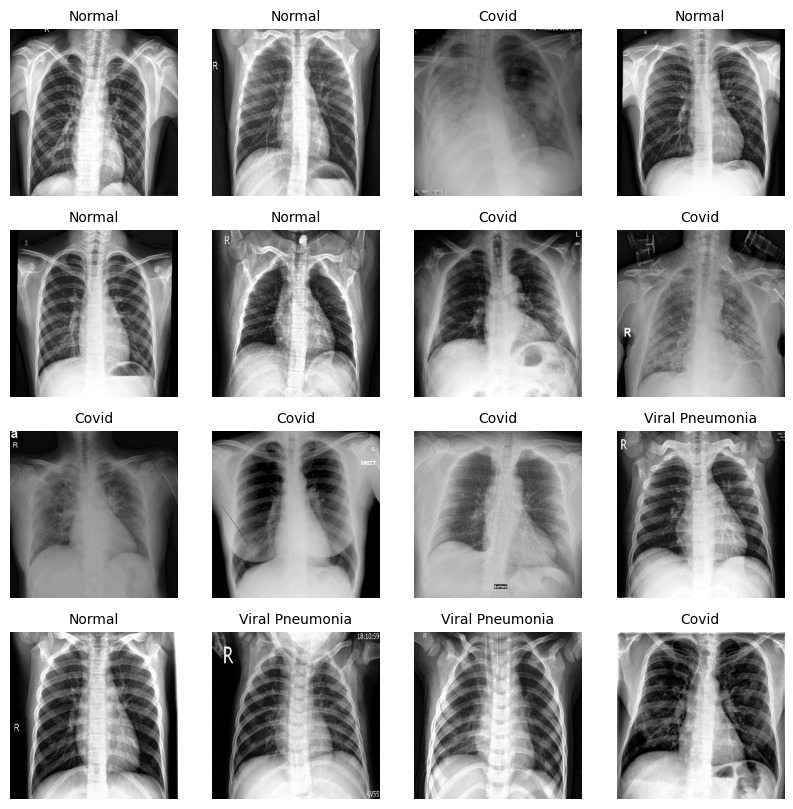

In [27]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i], fontsize=10)
    plt.axis('off')
plt.show()

In [28]:
class_to_index = {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
y_train_numeric = [class_to_index[label] for label in y_train]
y_train_numeric = np.array(y_train_numeric)

print(len(y_train_numeric))
print(len(X_train))

251
251


In [29]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu', input_shape=(400, 400,1)))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

# Warstwy gęsto połączone
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(400, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [30]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [31]:
batch_size = 4

history = model.fit(X_train, y_train_numeric, epochs=100, batch_size=batch_size,shuffle=True,)
model.save("COVID")

Epoch 1/100
 6/63 [=>............................] - ETA: 1:59 - loss: 1.2111 - accuracy: 0.3750

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
loss, accuracy=model.evaluate(X_test,y_test)
print(f'Loss={loss}')
print(f'{accuracy * 100:.2f}%')


In [ ]:
y_pred = model.predict(X_train)
y_pred_classes = tf.argmax(y_pred, axis=1)

confusion_matrix = tf.math.confusion_matrix(y_train, y_pred_classes)
print(confusion_matrix)



plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


plt.show()